Import required python packages

In [1]:
import numpy as np
import numpy.ma as ma
import networkx as nx
import copy
import heapq as hq
from collections import defaultdict
from matplotlib import pyplot as plt

# Set game mode
ABSOLUTE = True
CELL_MAX = 10
GRID_SIZE = 10

Implement Dijkstra algorithm 

In [2]:
def generate_dijkstra_path(grid: np.ndarray):
    # Generate grid of the same size as the input grid
    path = np.zeros((GRID_SIZE, GRID_SIZE), dtype=bool)
    # Generate a graph from the grid size
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE)
    for edge in G.edges():
        if ABSOLUTE:
            # Set the weight of each edge to the abs value of the two vertices
            G[edge[0]][edge[1]]['w'] = np.absolute(
                grid[edge[0][0], edge[0][1]] - grid[edge[1][0], edge[1][1]])
        else:
            # Set the weight of each edge to the sum of the two vertices
            G[edge[0]][edge[1]]['w'] = grid[edge[0][0],
                                            edge[0][1]] + grid[edge[1][0], edge[1][1]]
    # Define the start and end node
    start_node = (0, 0)
    target_node = (GRID_SIZE-1, GRID_SIZE-1)

    # Collect visited nodes
    visited_nodes = set()
    # Define the queue
    node_mappings = {}
    # Define the priority queue
    priority_queue = []
    node_costs = defaultdict(lambda: float('inf'))
    node_costs[start_node] = 0
    hq.heappush(priority_queue, (0, start_node))

    # Loop until the end node is reached (this is the algorithm)
    while priority_queue:
        # Get the node with the lowest cost, greedily
        _, node = hq.heappop(priority_queue)
        # Add the current node to the visited nodes
        visited_nodes.add(node)
        # Check if end node is reached
        if node == target_node:
            break
        # Get the neighbours of the current node
        for next_node, weight in G[node].items():
            # Check if the neighbour is already visited
            if next_node in visited_nodes:
                continue
            updated_cost = node_costs[node] + weight.get('w')
            # If the cost is lower than the current cost, update the cost and push the node to the queue
            if updated_cost < node_costs[next_node]:
                # Update the cost and mapping
                node_mappings[next_node] = node
                node_costs[next_node] = updated_cost
                hq.heappush(priority_queue, (updated_cost, next_node))

    # Reconstruct the path
    final_path = []
    current_node = target_node
    final_path.append(current_node)
    # Iterate until the start node is reached
    while current_node != start_node:
        current_node = node_mappings[current_node]
        final_path.append(current_node)
    # Update the path mask with the final path
    for node in final_path:
        path[node[0], node[1]] = True
    # Return the correct path total depending on the game mode
    if ABSOLUTE:
        total_cost = node_costs[target_node]
    else:
        total_cost = ma.masked_where(path == False, grid).sum()
    # Return path and total cost
    return path, total_cost


Implement the Heuristic Algorithm

In [3]:
def generate_heuristic_path(grid: np.ndarray):
    # Generate grid of the same size as the input grid
    path = np.zeros((GRID_SIZE, GRID_SIZE), dtype=bool)
    # Generate a graph from the grid size
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE)
    for edge in G.edges():
        if ABSOLUTE:
            # Set the weight of each edge to the abs value of the two vertices
            G[edge[0]][edge[1]]['w'] = np.absolute(
                grid[edge[0][0], edge[0][1]] - grid[edge[1][0], edge[1][1]])
        else:
            # Set the weight of each edge to the sum of the two vertices
            G[edge[0]][edge[1]]['w'] = grid[edge[0][0],
                                            edge[0][1]] + grid[edge[1][0], edge[1][1]]

    # Define the start and end node
    start_node = (0, 0)
    target_node = (GRID_SIZE-1, GRID_SIZE-1)
    end_reached = False
    # Set current node
    current_node = start_node
    # Define direction vectors
    right_add = (0, 1)
    down_add = (1, 0)
    # Set start node as visited
    path[current_node] = True
    total = 0
    while not end_reached:
        # Genereate the neighbours position of the current node
        right_cell_pos = tuple(np.add(current_node,right_add))
        down_cell_pos = tuple(np.add(current_node,down_add))
        # Get the neighbours of the current node
        adjacent_nodes = G[current_node]

        # Check if the right neighbour is valid
        if right_cell_pos in adjacent_nodes:
            right_cell_weight = adjacent_nodes[right_cell_pos].get('w')
        else:
            right_cell_weight = -1
        # Check if the down neighbour is valid
        if down_cell_pos in adjacent_nodes:
            down_cell_weight = adjacent_nodes[down_cell_pos].get('w')
        else:
            down_cell_weight = -1
        # If the right neighbour is not valid, go down
        if right_cell_weight == -1 and down_cell_weight != -1:
            total += down_cell_weight
            current_node = down_cell_pos
        # If the down neighbour is not valid, go right
        elif down_cell_weight == -1 and right_cell_weight != -1:
            total += right_cell_weight
            current_node = right_cell_pos
        # If both neighbours are valid, go right if the right neighbour has a lower weight
        elif right_cell_weight < down_cell_weight:
            total += right_cell_weight
            current_node = right_cell_pos
        # If both neighbours are valid, go down if the down neighbour has a lower weight
        elif down_cell_weight < right_cell_weight:
            total += down_cell_weight
            current_node = down_cell_pos
        # If both neighbours have the same weight, go down
        else:
            total += down_cell_weight
            current_node = down_cell_pos
        # Set current position as visited
        path[current_node] = True
        # Check if the end node is reached
        if current_node == target_node:
            end_reached = True
    # Return the correct path total depending on the game mode
    if not ABSOLUTE:
        total = ma.masked_where(path == False, grid).sum()
    # Return path and total cost
    return path, total


Display the path replace x and y with generated numbers and --- with red colour

In [4]:
#displays the path
def display_plot(grid, solved_path, path_total, title): 
    solved_path_mask = np.ma.masked_where(solved_path == True, solved_path)
    current_cmap = copy.copy(plt.get_cmap('PuRd'))
    # transform --- to colour (red)
    current_cmap.set_bad(color='red')
    _, ax = plt.subplots(figsize=(7, 7))
    # Createt 2d matrix
    ax.matshow(grid)
    ax.matshow(solved_path_mask, cmap=current_cmap)

    # Add cell value to text
    for (pos_y, pos_x), value in np.ndenumerate(grid):
      ax.text(pos_x, pos_y, str(value), ha='center', va='center')

    # Add height and width of grid to the plot
    ax.set_xlabel(GRID_SIZE)
    ax.set_ylabel(GRID_SIZE)

    # Remove x and y ticks and labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    # Set the title and show the plot
    plt.title(f"Total: {path_total}")
    if ABSOLUTE:
        plt.suptitle(f'{title} - Absolute')
    else:
        plt.suptitle(f'{title} - Normal')
    plt.show()


Generate and display the grid


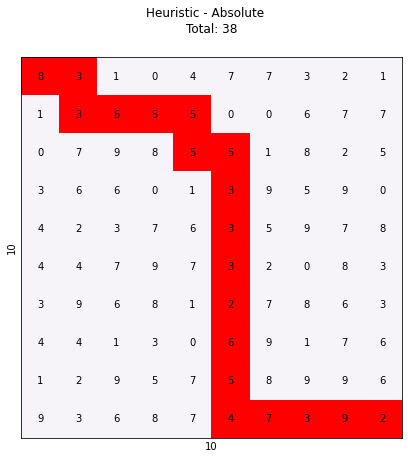

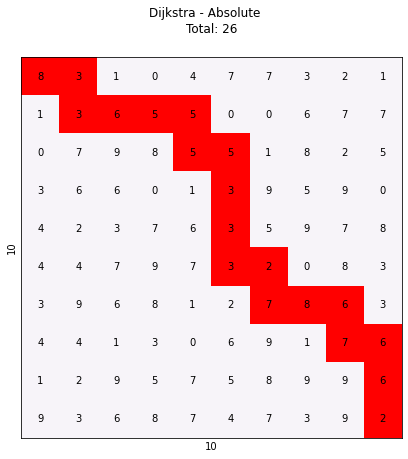

In [5]:
def generate_grid_values():
    return np.random.randint(0, CELL_MAX, size=(GRID_SIZE, GRID_SIZE))


grid = generate_grid_values()

# Pass generated grid to Heuristic function to generate solved path and total cost
solved_path_heuristic_mask, heuristic_path_total = generate_heuristic_path(grid)
# Display grid and solved path with total cost
display_plot(grid, solved_path_heuristic_mask, heuristic_path_total, "Heuristic")

# Pass generated grid to Dijkstra function to generate solved path and total cost
solved_path_dijkstra_mask, dijkstra_path_total = generate_dijkstra_path(grid)
# Display grid and solved path with total cost
display_plot(grid, solved_path_dijkstra_mask, dijkstra_path_total, "Dijkstra")
